In [22]:
import sys

# IT'S 2025 WHY HASN'T SOMEONE FIXED THIS
if ".." not in sys.path:
    sys.path.insert(0, "..")
    
from collections import defaultdict
from pathlib import Path
import ast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from tqdm.auto import tqdm

from src import aposteriori
import tasks.graphs


GRAPH_DIR = Path("../graphs")

In [23]:
df = pd.read_csv(
    "../data/100_annotators.csv",
    converters={"annot_personality_characteristics": ast.literal_eval},
)
df["toxicity"] = df.annotation.apply(lambda x: x[-1]).astype(int)
df["annot_politics"] = df.annot_personality_characteristics.apply(
    lambda x: x[0]
)
df.annot_age = pd.cut(df.annot_age, bins=4)
df.message_id = df.message_id.astype(str)
df["comment_key"] = df.conv_id + df.message_id

df = df.loc[
    :,
    [
        "conv_id",
        "message_id",
        "comment_key",
        "message",
        "toxicity",
        "annot_age",
        "annot_sex",
        "annot_sexual_orientation",
        "annot_demographic_group",
        "annot_current_employment",
        "annot_education_level",
        "annot_politics",
    ],
]
df = df.groupby(["conv_id", "message_id", "comment_key", "message"]).apply(
    lambda x: pd.Series(
        {
            col: x[col].tolist()
            for col in df.columns
            if col not in ["conv_id", "message_id", "comment_key", "message"]
        }
    ),
    include_groups=False,
)
df["fake_index"] = 1

In [28]:
def sample_se_vs_sample_size_unimodality(
    df: pd.DataFrame,
    annotation_col: str,
    group_col: str,
    comment_col: str,
    bins: int = 5,
    min_size: int = 2,
    max_size: int = 100,
    step: int = 10,
    iters: int = 30,
) -> pd.DataFrame:
    """
    Sample decreasing subsets of annotations and compute the standard error
    of Aposteriori Unimodality statistics at each sample size.

    :param df: DataFrame with annotations, factor groups, and comment ids.
    :param annotation_col: Column name for list of annotations.
    :param group_col: Column name for list of factor groups (e.g., annot_sex).
    :param comment_col: Column name for list of comment ids.
    :param bins: Number of bins for DFU.
    :param min_size: Minimum sample size to consider.
    :param max_size: Maximum sample size to consider.
    :param step: Step size to decrease sample size.
    :param iters: Repetitions per sample size for averaging.
    :return: DataFrame with columns [sample_size, standard_error]
    """
    results: list[dict[str, Any]] = []
    for size in tqdm(range(min_size, max_size + 1, step), desc="#Annotators"):
        iter_ses = []

        for _ in tqdm(range(iters), desc="#Comments", leave=False):
            sample_stats = []

            # loop over comments
            for _, row in df.iterrows():
                annotations = np.array(row[annotation_col])
                groups = np.array(row[group_col])

                # skip if not enough annotators
                if len(annotations) < size:
                    continue

                # subsample
                idx = np.random.choice(
                    len(annotations), size=size, replace=False
                )
                sub_ann = annotations[idx]
                sub_grp = groups[idx]

                # compute factor DFU stats
                stats_dict = aposteriori._factor_dfu_stat(
                    sub_ann, sub_grp, bins=bins
                )

                # collect values (drop NaNs)
                sample_stats.extend(
                    [v for v in stats_dict.values() if not np.isnan(v)]
                )

            # compute SE for this iteration
            if len(sample_stats) > 1:
                se = np.std(sample_stats, ddof=1) / np.sqrt(len(sample_stats))
                iter_ses.append(se)

        # average SE across iterations
        if len(iter_ses) > 0:
            results.append(
                {"sample_size": size, "standard_error": np.mean(iter_ses)}
            )

    return pd.DataFrame(results)


res_df = sample_se_vs_sample_size_unimodality(
    df=df.reset_index(),
    annotation_col="toxicity",
    group_col="annot_sex",
    comment_col="message_id",
    bins=5,
    min_size=3,
    max_size=100,
    step=1,
    iters=1000,
)
res_df

#Annotators:   0%|          | 0/98 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

#Comments:   0%|          | 0/1000 [00:00<?, ?it/s]

,sample_size,standard_error
0,3,0.039703
1,4,0.041574
2,5,0.041691
3,6,0.042541
4,7,0.042044
...,...,...
93,96,0.036153
94,97,0.036132
95,98,0.036125
96,99,0.036132


Figure saved to /home/dimits/Documents/research/aposteriori-unimodality/graphs/ndfu_std_error_sample_size.png


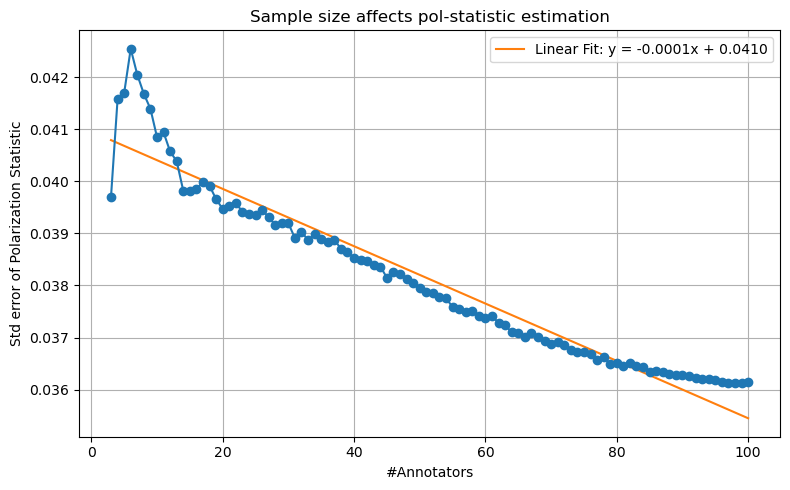

In [29]:
def plot_variance_curve(results_df: pd.DataFrame):
    results_df = results_df.sort_values("sample_size")

    x = results_df["sample_size"].values.reshape(-1, 1)
    y = results_df["standard_error"].values

    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)

    plt.figure(figsize=(8, 5))
    plt.plot(
        x,
        y_pred,
        label=f"Linear Fit: y = {model.coef_[0]:.4f}x + {model.intercept_:.4f}",
        color="tab:orange",
    )
    plt.plot(x, y, color="tab:blue", marker="o")
    plt.xlabel("#Annotators")
    plt.ylabel("Std error of Polarization Statistic")
    plt.title("Sample size affects pol-statistic estimation")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()


# Example usage
plot_variance_curve(res_df)
tasks.graphs.save_plot(GRAPH_DIR / "ndfu_std_error_sample_size.png")
plt.show()